In [1]:
import numpy as np
import networkx as nx
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import json
from model import *
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
np.random.seed(12345)
tf.random.set_seed(12345)

In [3]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)

In [4]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

In [5]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 80% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.8
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (2157, 1435)
Test data shape: (551, 1435)


In [10]:
from tf_agents.specs import tensor_spec
from tf_agents.networks import sequential

fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

(2708, 2707)

In [6]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data.paper_id.to_numpy()
x_test = test_data.paper_id.to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"].to_numpy()
y_test = test_data["subject"].to_numpy()

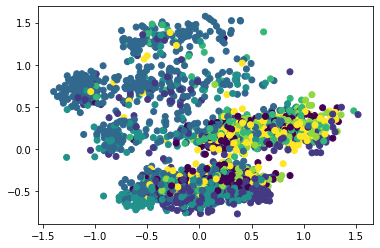

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data = pca.fit_transform(papers[feature_names])
plt.scatter(data[:, 0], data[:, 1], c=papers['subject'])
plt.show()

In [8]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

In [9]:
def actions(x_train, y_train, graph_info, attacked_nodes):
    (node_features, edges, edge_weights) = graph_info 
    
    # pick a node v
    edge_num = citations[["source", "target"]].groupby('source').count().reset_index() \
        .sort_values(by='target', ascending=False).reset_index(drop=True)
    for i in range(len(edge_num)):
        if edge_num.iloc[i, 0] not in attacked_nodes:
            v = edge_num.iloc[i, 0]
            break
    
    # create fake node vf
    vf = edge_num['source'].max() + len(attacked_nodes) + 1
    attacked_nodes.add(vf)
    x_train = np.append(x_train, vf)
    label = np.random.randint(7)
    while label == y_train[v]:
        label = np.random.randint(7)
    y_train = np.append(y_train, label)
    temp = node_features.numpy()
    node_features = tf.cast(np.vstack((temp, temp[v])), dtype=tf.dtypes.float32)
    
    # create/delete edges
    edges = np.append(edges, [[v, vf], [vf, v]], axis=1)
    for i in range(len(edges)):
        if edges[i][0] == v:
            if np.random.random() < 0.5:
                edges[i][0] = vf
        elif edges[i][1] == v:
            if np.random.random() < 0.5:
                edges[i][1] = vf
            
    edge_weights = tf.ones(shape=edges.shape[1])
    return x_train, y_train, (node_features, edges, edge_weights)

In [28]:
edge_num = citations[["source", "target"]].groupby('source').count().reset_index() \
    .sort_values(by='target', ascending=False).reset_index(drop=True)
attacked_nodes = set()

train_acc, test_acc = [], []

feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data.paper_id.to_numpy()
x_test = test_data.paper_id.to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"].to_numpy()
y_test = test_data["subject"].to_numpy()

# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
edges_attacked = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
edge_weights_attacked = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
node_features_attacked = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)
graph_info_attacked = (node_features_attacked, edges_attacked, edge_weights_attacked)

gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

history = run_experiment(gnn_model, x_train, y_train)

# display_learning_curves(history)

_, train_accuracy = gnn_model.evaluate(x=x_train, y=y_train, verbose=0)
train_acc.append(train_accuracy)
print(f"Train accuracy: {round(train_accuracy * 100, 2)}%", end='\t')

_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
test_acc.append(test_accuracy)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

for i in range(100):
    x_train, y_train, graph_info_attacked = actions(x_train, y_train, graph_info_attacked, attacked_nodes)
    
gnn_model = GNNNodeClassifier(
    graph_info=graph_info_attacked,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

history = run_experiment(gnn_model, x_train, y_train)

# display_learning_curves(history)

_, train_accuracy = gnn_model.evaluate(x=x_train, y=y_train, verbose=0)
train_acc.append(train_accuracy)
print(f"Train accuracy: {round(train_accuracy * 100, 2)}%", end='\t')


gnn_model.graph_info = graph_info
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
test_acc.append(test_accuracy)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Train accuracy: 96.66%	Test accuracy: 84.39%
Train accuracy: 91.63%	Test accuracy: 80.94%


In [10]:
train_acc_bf, test_acc_bf = [], []
train_acc_af, test_acc_af = [], []
for i in range(10):
    edge_num = citations[["source", "target"]].groupby('source').count().reset_index() \
        .sort_values(by='target', ascending=False).reset_index(drop=True)
    attacked_nodes = set()

    feature_names = set(papers.columns) - {"paper_id", "subject"}
    num_features = len(feature_names)
    num_classes = len(class_idx)

    # Create train and test features as a numpy array.
    x_train = train_data.paper_id.to_numpy()
    x_test = test_data.paper_id.to_numpy()
    # Create train and test targets as a numpy array.
    y_train = train_data["subject"].to_numpy()
    y_test = test_data["subject"].to_numpy()

    # Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
    edges = citations[["source", "target"]].to_numpy().T
    edges_attacked = citations[["source", "target"]].to_numpy().T
    # Create an edge weights array of ones.
    edge_weights = tf.ones(shape=edges.shape[1])
    edge_weights_attacked = tf.ones(shape=edges.shape[1])
    # Create a node features array of shape [num_nodes, num_features].
    node_features = tf.cast(
        papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
    )
    node_features_attacked = tf.cast(
        papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
    )
    # Create graph info tuple with node_features, edges, and edge_weights.
    graph_info = (node_features, edges, edge_weights)
    graph_info_attacked = (node_features_attacked, edges_attacked, edge_weights_attacked)

    gnn_model = GNNNodeClassifier(
        graph_info=graph_info,
        num_classes=num_classes,
        hidden_units=hidden_units,
        dropout_rate=dropout_rate,
        name="gnn_model",
    )

    history = run_experiment(gnn_model, x_train, y_train)

    # display_learning_curves(history)

    _, train_accuracy = gnn_model.evaluate(x=x_train, y=y_train, verbose=0)
    train_acc_bf.append(train_accuracy)
    print(f"Train accuracy: {round(train_accuracy * 100, 2)}%", end='\t')

    _, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
    test_acc_bf.append(test_accuracy)
    print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

    for i in range(100):
        x_train, y_train, graph_info_attacked = actions(x_train, y_train, graph_info_attacked, attacked_nodes)
        
    gnn_model = GNNNodeClassifier(
        graph_info=graph_info_attacked,
        num_classes=num_classes,
        hidden_units=hidden_units,
        dropout_rate=dropout_rate,
        name="gnn_model",
    )

    history = run_experiment(gnn_model, x_train, y_train)

    # display_learning_curves(history)

    _, train_accuracy = gnn_model.evaluate(x=x_train, y=y_train, verbose=0)
    train_acc_af.append(train_accuracy)
    print(f"Train accuracy: {round(train_accuracy * 100, 2)}%", end='\t')


    gnn_model.graph_info = graph_info
    _, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
    test_acc_af.append(test_accuracy)
    print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")
    print()

Train accuracy: 97.13%	Test accuracy: 86.57%
Train accuracy: 92.78%	Test accuracy: 85.12%

Train accuracy: 95.87%	Test accuracy: 82.21%
Train accuracy: 94.42%	Test accuracy: 84.75%

Train accuracy: 96.99%	Test accuracy: 85.3%
Train accuracy: 92.6%	Test accuracy: 84.03%

Train accuracy: 97.13%	Test accuracy: 84.21%
Train accuracy: 93.35%	Test accuracy: 84.39%

Train accuracy: 96.43%	Test accuracy: 82.4%
Train accuracy: 93.4%	Test accuracy: 84.94%

Train accuracy: 97.31%	Test accuracy: 83.48%
Train accuracy: 92.87%	Test accuracy: 82.4%

Train accuracy: 97.26%	Test accuracy: 85.3%
Train accuracy: 93.89%	Test accuracy: 83.48%

Train accuracy: 96.01%	Test accuracy: 82.4%
Train accuracy: 92.6%	Test accuracy: 82.94%

Train accuracy: 96.29%	Test accuracy: 84.57%
Train accuracy: 94.2%	Test accuracy: 85.12%

Train accuracy: 96.38%	Test accuracy: 84.03%
Train accuracy: 93.58%	Test accuracy: 84.75%



In [23]:
for i in range(10):
    print(f'${round(train_acc_af[i] * 100, 2)}\\%$ (${round(train_acc_bf[i] * 100, 2)}\\%$)', end='')
    if train_acc_af[i] < train_acc_bf[i]:
        print(f'& \\boldmath${round(train_acc_af[i] * 100-train_acc_bf[i] * 100, 2)}\\%$', end='')
    else:
        print(f'& ${round(train_acc_af[i] * 100-train_acc_bf[i] * 100, 2)}\\%$', end='')
    print(f'& ${round(test_acc_af[i] * 100, 2)}\\%$ (${round(test_acc_bf[i] * 100, 2)}\\%$)', end='')
    if test_acc_af[i] < test_acc_bf[i]:
        print(f'& \\boldmath${round(test_acc_af[i] * 100-test_acc_bf[i] * 100, 2)}\\%$ \\\\ ')
    else:
        print(f'& ${round(test_acc_af[i] * 100-test_acc_bf[i] * 100, 2)}\\%$ \\\\ ')

$92.78\%$ ($97.13\%$)& \boldmath$-4.35\%$& $85.12\%$ ($86.57\%$)& \boldmath$-1.45\%$ \\ 
$94.42\%$ ($95.87\%$)& \boldmath$-1.46\%$& $84.75\%$ ($82.21\%$)& $2.54\%$ \\ 
$92.6\%$ ($96.99\%$)& \boldmath$-4.39\%$& $84.03\%$ ($85.3\%$)& \boldmath$-1.27\%$ \\ 
$93.35\%$ ($97.13\%$)& \boldmath$-3.77\%$& $84.39\%$ ($84.21\%$)& $0.18\%$ \\ 
$93.4\%$ ($96.43\%$)& \boldmath$-3.03\%$& $84.94\%$ ($82.4\%$)& $2.54\%$ \\ 
$92.87\%$ ($97.31\%$)& \boldmath$-4.44\%$& $82.4\%$ ($83.48\%$)& \boldmath$-1.09\%$ \\ 
$93.89\%$ ($97.26\%$)& \boldmath$-3.38\%$& $83.48\%$ ($85.3\%$)& \boldmath$-1.81\%$ \\ 
$92.6\%$ ($96.01\%$)& \boldmath$-3.41\%$& $82.94\%$ ($82.4\%$)& $0.54\%$ \\ 
$94.2\%$ ($96.29\%$)& \boldmath$-2.1\%$& $85.12\%$ ($84.57\%$)& $0.54\%$ \\ 
$93.58\%$ ($96.38\%$)& \boldmath$-2.81\%$& $84.75\%$ ($84.03\%$)& $0.73\%$ \\ 


In [11]:
# edge_num = citations[["source", "target"]].groupby('source').count().reset_index() \
#     .sort_values(by='target', ascending=False).reset_index(drop=True)
# attacked_nodes = set()

# train_acc, test_acc = [], []

# # while True:
# for i in range(10):
#     gnn_model = GNNNodeClassifier(
#         graph_info=graph_info,
#         num_classes=num_classes,
#         hidden_units=hidden_units,
#         dropout_rate=dropout_rate,
#         name="gnn_model",
#     )

#     history = run_experiment(gnn_model, x_train, y_train)

#     # display_learning_curves(history)

#     _, train_accuracy = gnn_model.evaluate(x=x_train, y=y_train, verbose=0)
#     train_acc.append(train_accuracy)
#     print(f"Train accuracy: {round(train_accuracy * 100, 2)}%", end='\t')

#     _, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
#     test_acc.append(test_accuracy)
#     print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

#     x_train, y_train, graph_info = actions(x_train, y_train, graph_info, attacked_nodes)
    
#     # if len(test_acc) > 2 and test_acc[-1] >= test_acc[-2] and test_acc[-1] >= test_acc[-3]:
#     #     break

In [12]:
# plt.plot(range(1, len(train_acc)+1), train_acc)
# plt.plot(range(1, len(test_acc)+1), test_acc)
# plt.legend(["train", "test"], loc="upper right")
# plt.xlabel("Epochs")
# plt.ylabel("Acc")
# plt.show()